# MACS207b Project: Estimate of a Hawkes process

- By Tancrède Martinez

# Context

In Cyber security, attacks often occur by bursts. The file

https://nextcloud.r2.enst.fr/nextcloud/index.php/s/DzfPE8Axx2H2afM

contains the dates of plenty of attacks, sorted by category and date of appearance. See the file

https://nextcloud.r2.enst.fr/nextcloud/index.php/s/xW2b6FF9ikPR8Gs

for a complete description of its content and of the motivations behind this analysis. We are going to make a simplified analysis by modeling time of attacks by a Hawkes process with intensity


$$
\begin{align*} 
\dot{y}(N,t) &= \alpha + \beta\int_{0}^{t^-} e^{-\gamma(t-s)} \, dN(s) \\
&= \alpha + \beta\sum_{T_q<t} e^{-\gamma(t-T_q)} \
\end{align*}
$$

We recall that from Exercise 3.4.2, we know that log-likelihood is given by

$$logL(N,t)=\sum_{T_n \leq t} log(\alpha+\beta \sum_{j=1}^{n-1} e^{-\gamma(T_n-T_j)}) +(1-\alpha)t-\frac \beta \gamma\sum_{T_n \leq t}(1-e^{-\gamma(t-T_n)}). $$

# Your work
- Extract from the file above the attacks of type “HACK”. Here is my code (which probably can be improved)

import pandas as pd

from datetime import datetime

from scipy.optimize import minimize,root_scalar

import numpy as np

import matplotlib.pylab as plt

df=pd.read_csv("PRC.csv",sep=';')

dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']

dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))

debut=min(dff)

dff=dff-debut

dff=dff.apply(lambda x:x.days).sort_values()

l=np.asarray(dff)[1:]

plt.scatter(l,1+np.arange(len(l)),s=0.1)

plt.show()

The dates are expressed in days starting from the first event.

- Using the scipy optimization library, estimate α,β,γ

 which maximize the log-likelihood for these data.

- Now that we have an estimate of y(N,t)
, we know that in theory, the sequence

$(y(N,T_q(N)),n≥1)$

must have the law of a Poisson process of intensity 1
. Compute this sequence and run the test you want on the inter-arrivals to assess the proximity between it and the law of a Poisson process.

In [420]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import kstest,expon

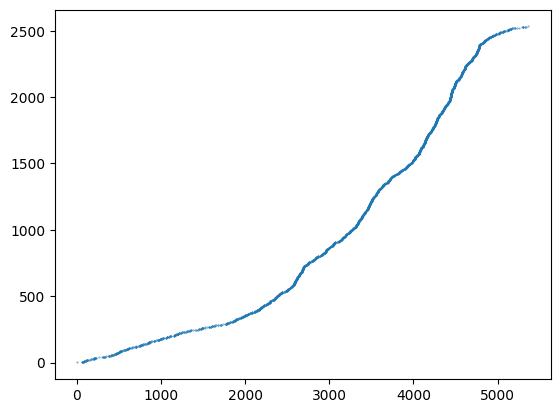

In [421]:
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
plt.scatter(l,1+np.arange(len(l)),s=0.1)
plt.show()

### Estimation of $\alpha, \beta ,\gamma$

In [422]:
def log_likelihood(T,t,alpha,beta,gamma):
    #Compute the log likelihood L from previous formula
    log_L=(1-alpha)*t
    n=0
    while n<len(T) and T[n]<t:
        gap = T[n] - T[:n]
        log_L+=-(1-np.exp(-gamma*(t-T[n])))*beta/gamma
        log_L+=np.log(alpha+beta*np.sum(np.exp(-gamma * gap)))
        n+=1
    return log_L

constraints = [{'type': 'ineq', 'fun': lambda params: params[1] - params[2]},  # beta < gamma
          {'type': 'ineq', 'fun': lambda params: params[0]},  # alpha > 0
          {'type': 'ineq', 'fun': lambda params: params[1]},  # beta > 0
          {'type': 'ineq', 'fun': lambda params: params[2]}]  # gamma > 0

def neg_log_likelihood(params):
    #t correspond to l[-1] to maximise the information we have over the data.
    return -log_likelihood(l,l[-1],params[0],params[1],params[2])

x0=[0.5,0.5,1]
bounds = ((0, None), (0, None), (0, None))
res = minimize(neg_log_likelihood, x0, constraints=constraints,bounds=bounds,options={'maxiter': 1000})
#It seems that alpha beta and gamma are very dependant on initial value of minimize but their ratio are not. 
#It is not as important as it may seems because the ratios are the most important part when computing y. Next results are the same for different values of alpha, beta and gamma

# Extract the estimated parameter values
estimated_params = res.x
alpha,beta,gamma=estimated_params[0], estimated_params[1], estimated_params[2]
print("Estimated parameters:")
print("Alpha =", alpha)
print("Beta =", beta)
print("Gamma =", gamma)

C:\Users\fanto\AppData\Local\Temp\ipykernel_26316\1867241021.py:8: RuntimeWarning: divide by zero encountered in log
  log_L+=np.log(alpha+beta*np.sum(np.exp(-gamma * gap)))
C:\Users\fanto\AppData\Local\Temp\ipykernel_26316\1867241021.py:7: RuntimeWarning: invalid value encountered in scalar divide
  log_L+=-(1-np.exp(-gamma*(t-T[n])))*beta/gamma


Estimated parameters:
Alpha = 0.020831452502753714
Beta = 0.041733032361211515
Gamma = 0.041733032361211515


### Computation of y(N,t)

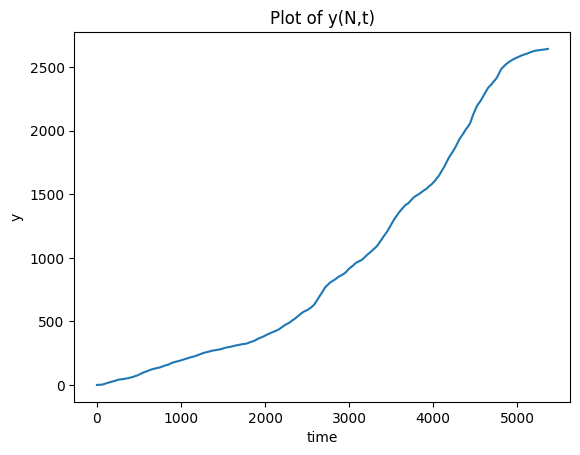

In [423]:
def dy(T,t,alpha,beta,gamma):
    #Compute the time derivative of y
    return alpha + beta*np.sum(np.exp(-gamma*(t-T[T<t])))

y=np.zeros(len(l))
time_scale=np.linspace(0,l[-1],len(l))
for i in range(1,len(l)):
    #We compute y with the rectangle method
    y[i]=dy(l,time_scale[i],alpha,beta,gamma)*(time_scale[i]-time_scale[i-1])+y[i-1]

plt.plot(time_scale, y)
plt.xlabel('time')
plt.ylabel('y')
plt.title('Plot of y(N,t)')
plt.show()

Our model models correctly the data hence we got the continous version of figure 1.

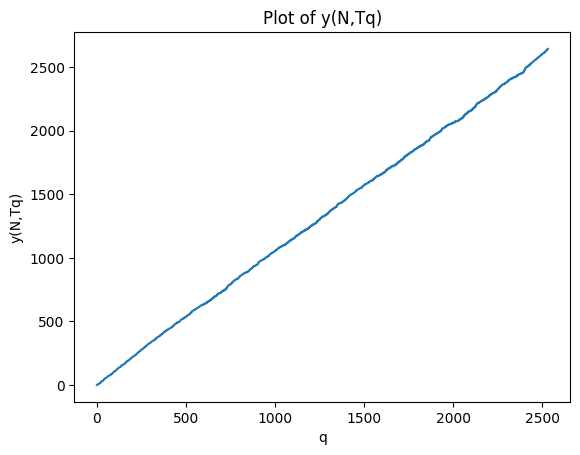

In [424]:
def index_q(time_scale,Tq):
    #Retrieve the best index approximating Tq in y
    q=0
    while q<len(time_scale):
        if time_scale[q]>Tq:
            return q
        else:
            q+=1
    return q-1

# We compute y_T such that y_T[q] is approximately y(N,Tq)
y_T=np.array([y[index_q(time_scale,Tq)] for Tq in l])
plt.plot(np.linspace(0,len(y_T),len(y_T)),y_T)
plt.xlabel('q')
plt.ylabel('y(N,Tq)')
plt.title('Plot of y(N,Tq)')
plt.show()

We observed that $y(N,T_q)$ seems to be quasi-linear of form $y(N,T_q) \approx q$ over all $T_q$ like a poisson process $\hat{T}$ of intensity 1 which verify $\mathbb{E}(\hat{T_q})=q$ (mean of gamma law of parameter q,1).

### Kolmogorov-Smirnov test and p-value

We know that if $(y(N,T_q))$ follow a poisson process of intensity 1 then the inter arrival $y(N,T_q)-y(N,T_{q-1})$ follows exponential law of parameter 1.

So we will perform a Kolmogorov-Smirov test on $y(N,T_q)-y(N,T_{q-1})$ assuming they are independant of each other to verify that $(y(N,T_q))$ follow a poisson process of intensity 1.

In [425]:
inter=np.array([y_T[q]-y_T[q-1] for q in range(1,len(y))])
_, p_value = kstest(inter, 'expon')
print('Exponential distribution test p value : ', p_value)


Exponential distribution test p value :  0.0


It seems that our test as failed hence the p value is smaller than 0.05 meaning inter arrivals don't follow exponential distribution.

Let look at the graph distribution of $y(N,T_q)-y(N,T_{q-1})$ to better understand.

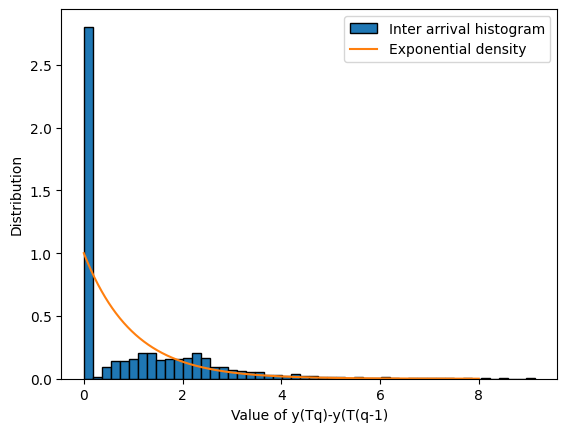

In [426]:
_=plt.hist(inter, bins=50, edgecolor='black', density=True, label='Inter arrival histogram')
distrib_val=np.linspace(0,8,1000)
plt.plot(distrib_val, np.exp(-distrib_val), label='Exponential density')
plt.xlabel('Value of y(Tq)-y(T(q-1)')
plt.ylabel('Distribution')
plt.legend()
plt.show()

We clearly see that the distribution does not follow an exponential law of any parameter ...

First, hence we see that the distribution over 0 is huge for our computed distribution, let's see if we get zero often with our computed $y(N,T_q)-y(N,T_{q-1})$ (it's an event of probability 0).


In [427]:
print('Number of 0 inter arrival : ',len(inter[inter==0]))

Number of 0 inter arrival :  1296


We see a clearly abnormal number.

It may come from the way we approximated $y(N,T_q)$.

Let's try by increasing the precision of y calculation letting more sample of y being computed.

In [428]:
factor=3 #multiplying by factor over 3 give the same results.
y2=np.zeros(int(factor*len(l)))
time_scale2=np.linspace(0,l[-1],int(factor*len(l)))
for i in range(1,int(factor*len(l))):
    y2[i]=dy(l,time_scale2[i],alpha,beta,gamma)*(time_scale2[i]-time_scale2[i-1])+y2[i-1]
y2_T=np.array([y2[index_q(time_scale2,Tq)] for Tq in l])
inter=np.array([y2_T[q]-y2_T[q-1] for q in range(1,len(y2_T))])

print('Number of 0 inter arrival : ',len(inter[inter==0]))

Number of 0 inter arrival :  953


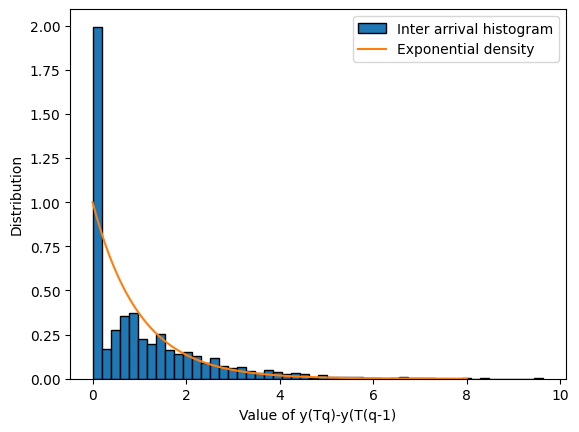

In [429]:
plt.hist(inter, bins=50, edgecolor='black', density=True, label='Inter arrival histogram')
distrib_val=np.linspace(0,8,1000)
plt.plot(distrib_val, np.exp(-distrib_val), label='Exponential density')
plt.xlabel('Value of y(Tq)-y(T(q-1)')
plt.ylabel('Distribution')
plt.legend()
plt.show()

In [430]:
_, p_value = kstest(inter, 'expon')
print('Exponential distribution test p value : ', p_value)


Exponential distribution test p value :  0.0


We see that the results are better, the inter arrival seems to have a closer to distribution to the exponential distribution than previously but the results are not sufficient, as proven by the computation of p_value. We can also see that the issue is only around 0.

To understand why increasing the accuracy factor doesn't improve the computed inter arrival array. Let print the number of days where we got multiple attacks.

In [431]:
len(l)-len(set(l))

953

We then deduce that the limiting factor is now that modeling attacks with days as time reference is not accurate enough tobe correctly approximated by a poisson process. 

So even if in theory our model is correct, the time-scale that has been chosen doesn't allow simulation to affirm or refute our modelisation.